In [1]:
import os
import random
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from PIL import Image
from matplotlib.image import imread
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [2]:
root = 'C:/Users/Admin/Desktop/Road-Sign-Recognition/src'
os.chdir(root)

In [3]:
data_dir = 'C:/Users/Admin/Desktop/Road-Sign-Recognition/src/road-sign-dataset'
train_path = 'C:/Users/Admin/Desktop/Road-Sign-Recognition/src/road-sign-dataset/Train'
test_path = 'C:/Users/Admin/Desktop/Road-Sign-Recognition/src/road-sign-dataset/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [4]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [5]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

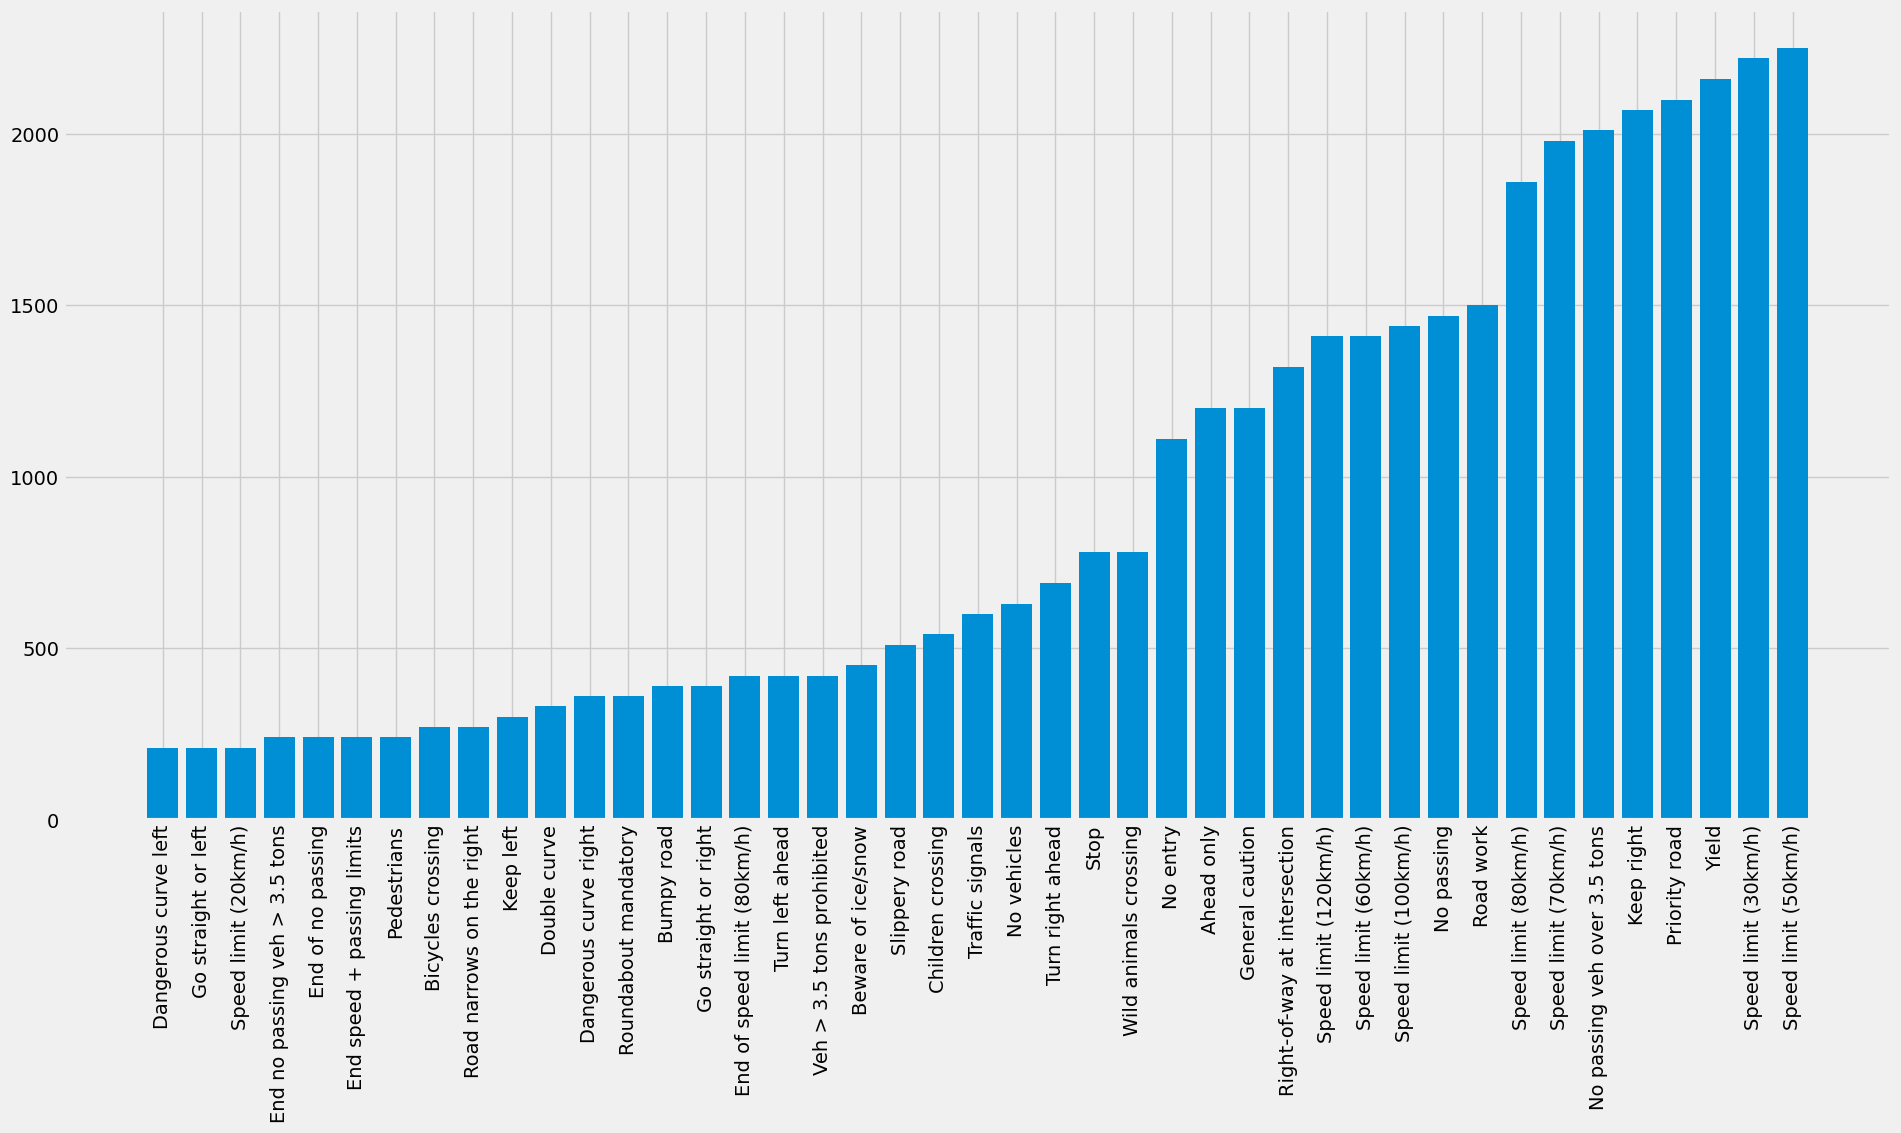

In [10]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation= 'vertical')
plt.show()

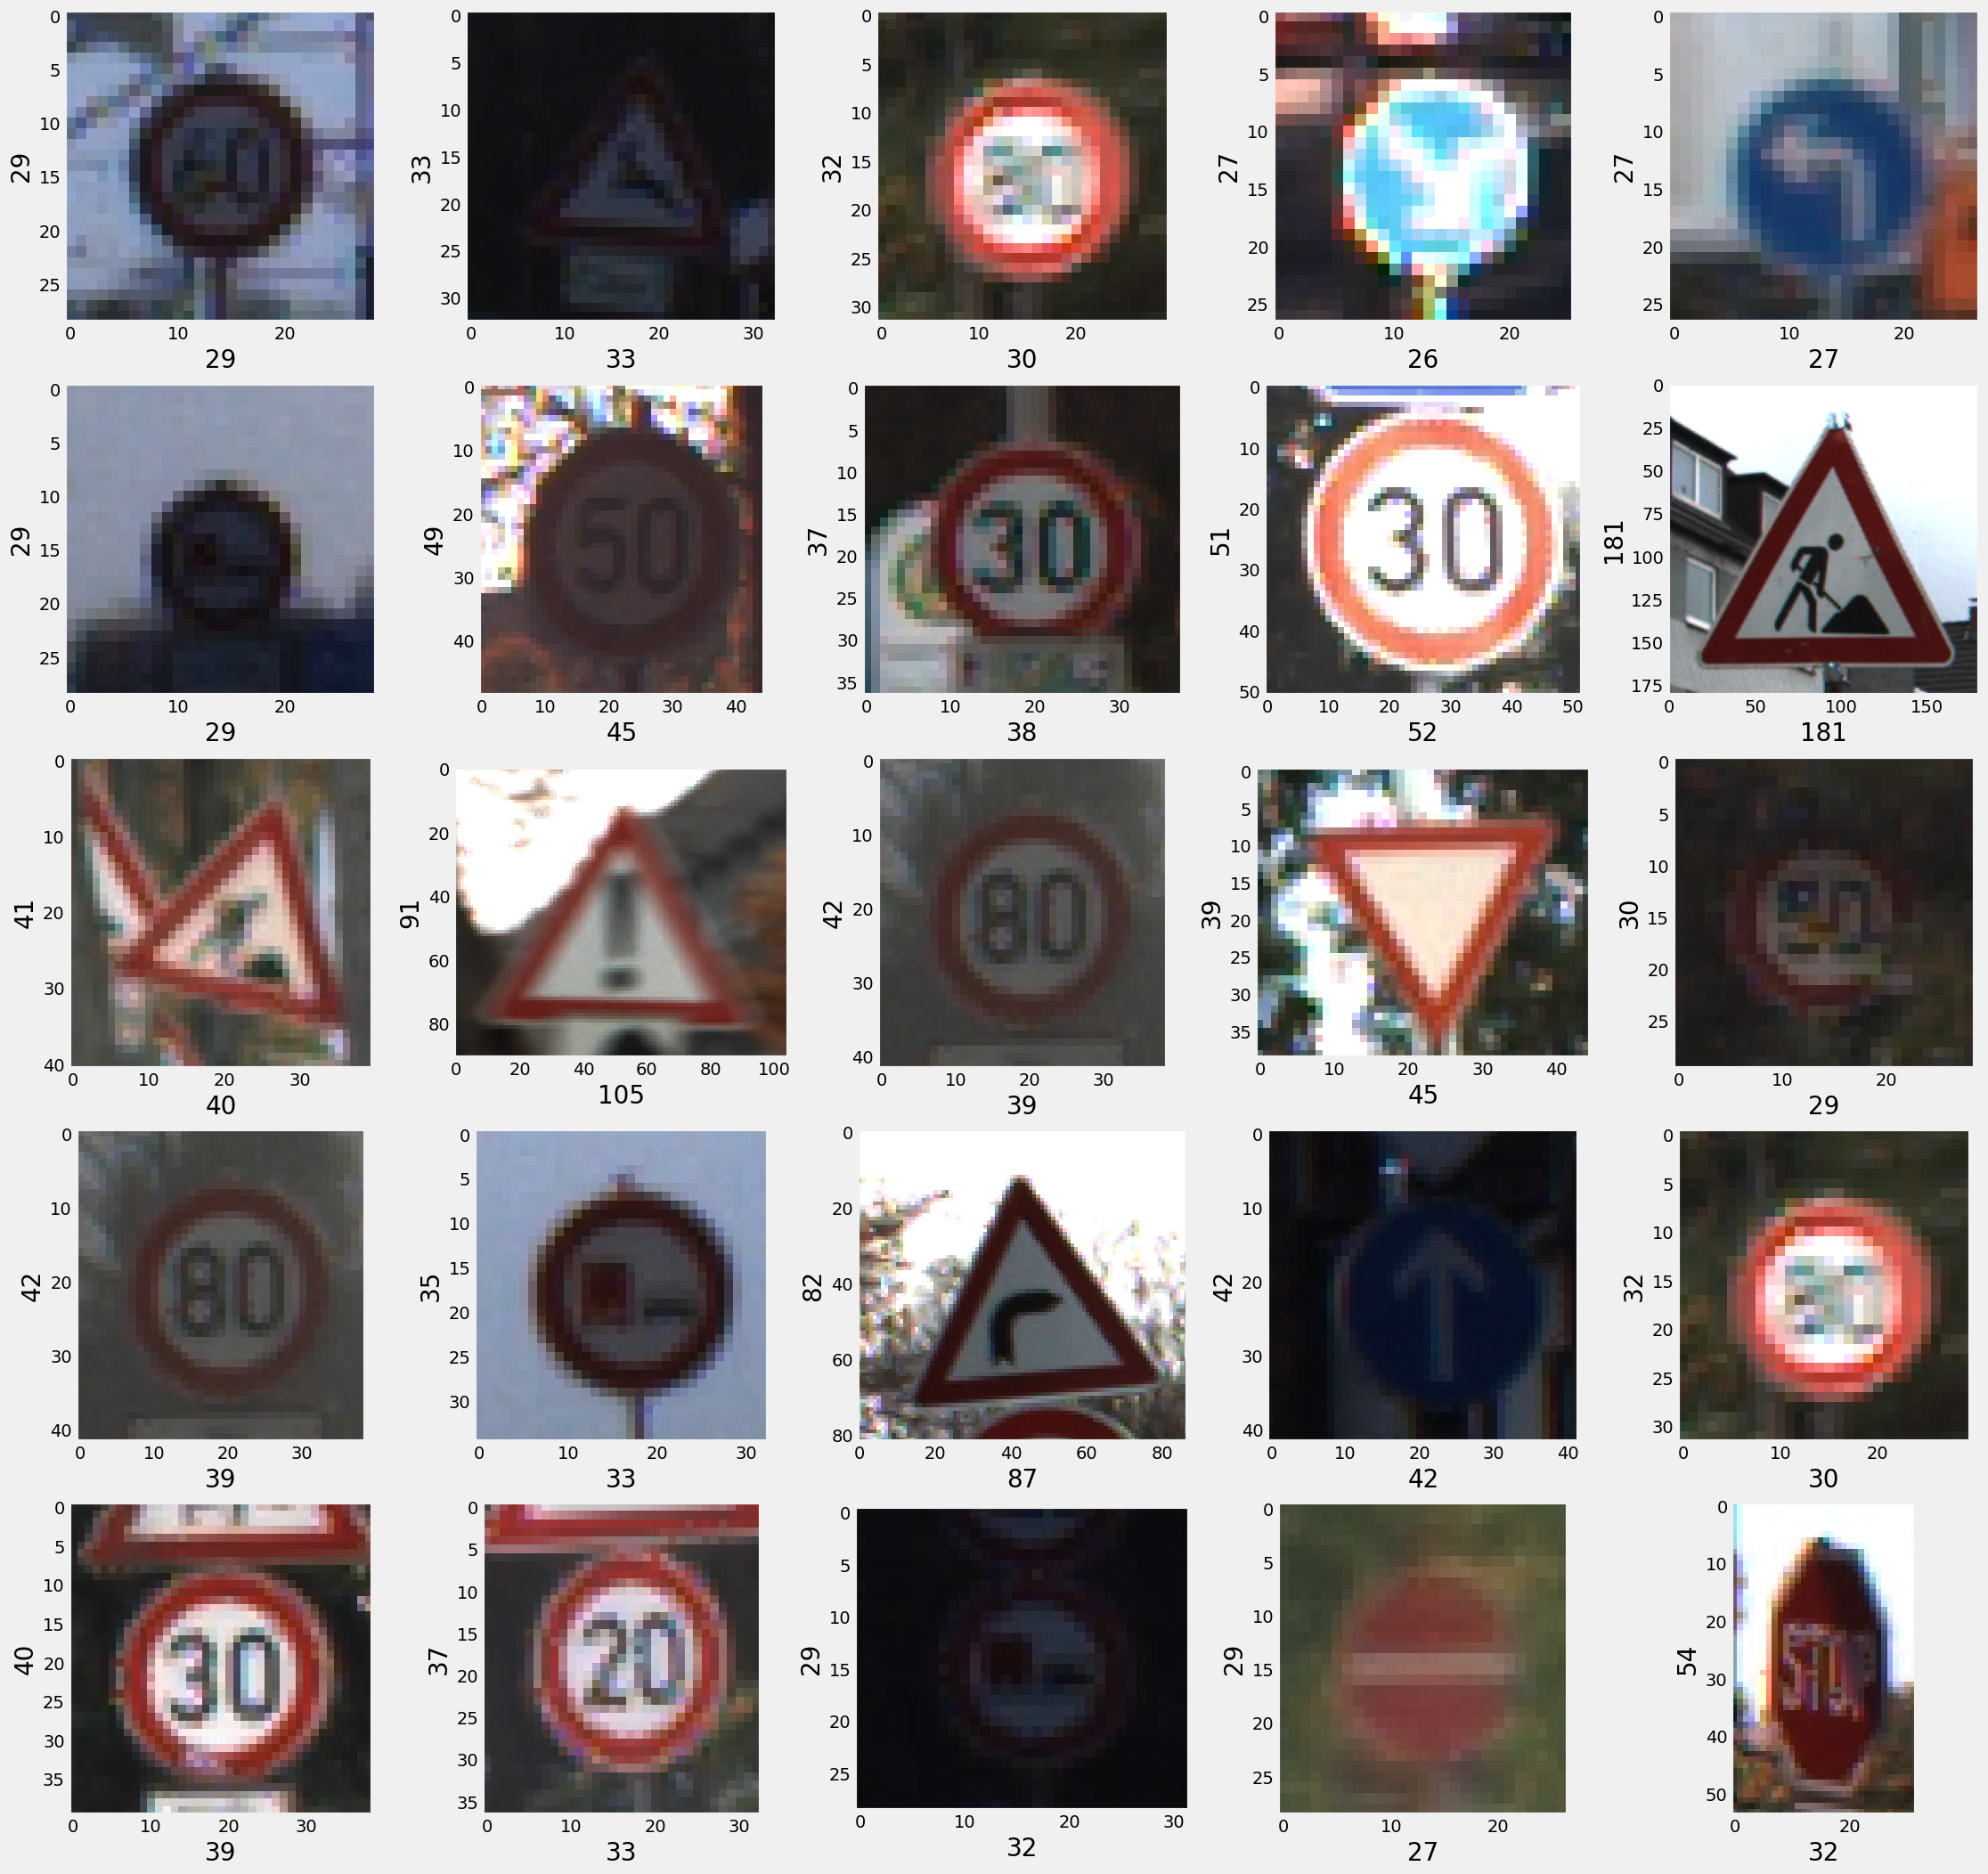

In [11]:
# Visualizing 25 random images from test data
test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(visible=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20) # width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20) # height of image

In [12]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [13]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [14]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [15]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [6]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])

In [7]:
lr = 0.001
epochs = 50
opt = Adam(learning_rate=lr, weight_decay= lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 13, 13, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 128)         7

In [20]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/50
858/858 [==============================] - 59s 65ms/step - loss: 1.0569 - accuracy: 0.7143 - val_loss: 0.1210 - val_accuracy: 0.9655
Epoch 2/50
858/858 [==============================] - 34s 40ms/step - loss: 0.1927 - accuracy: 0.9421 - val_loss: 0.0319 - val_accuracy: 0.9893
Epoch 3/50
858/858 [==============================] - 33s 38ms/step - loss: 0.1101 - accuracy: 0.9664 - val_loss: 0.0377 - val_accuracy: 0.9889
Epoch 4/50
858/858 [==============================] - 33s 39ms/step - loss: 0.1001 - accuracy: 0.9685 - val_loss: 0.0321 - val_accuracy: 0.9909
Epoch 5/50
858/858 [==============================] - 34s 40ms/step - loss: 0.0749 - accuracy: 0.9770 - val_loss: 0.0470 - val_accuracy: 0.9865
Epoch 6/50
858/858 [==============================] - 35s 41ms/step - loss: 0.0620 - accuracy: 0.9809 - val_loss: 0.0171 - val_accuracy: 0.9945
Epoch 7/50
858/858 [==============================] - 36s 42ms/step - loss: 0.0668 - accuracy: 0.9804 - val_loss: 0.0421 - val_accuracy:

In [21]:
model.save_weights('model_weights.h5')

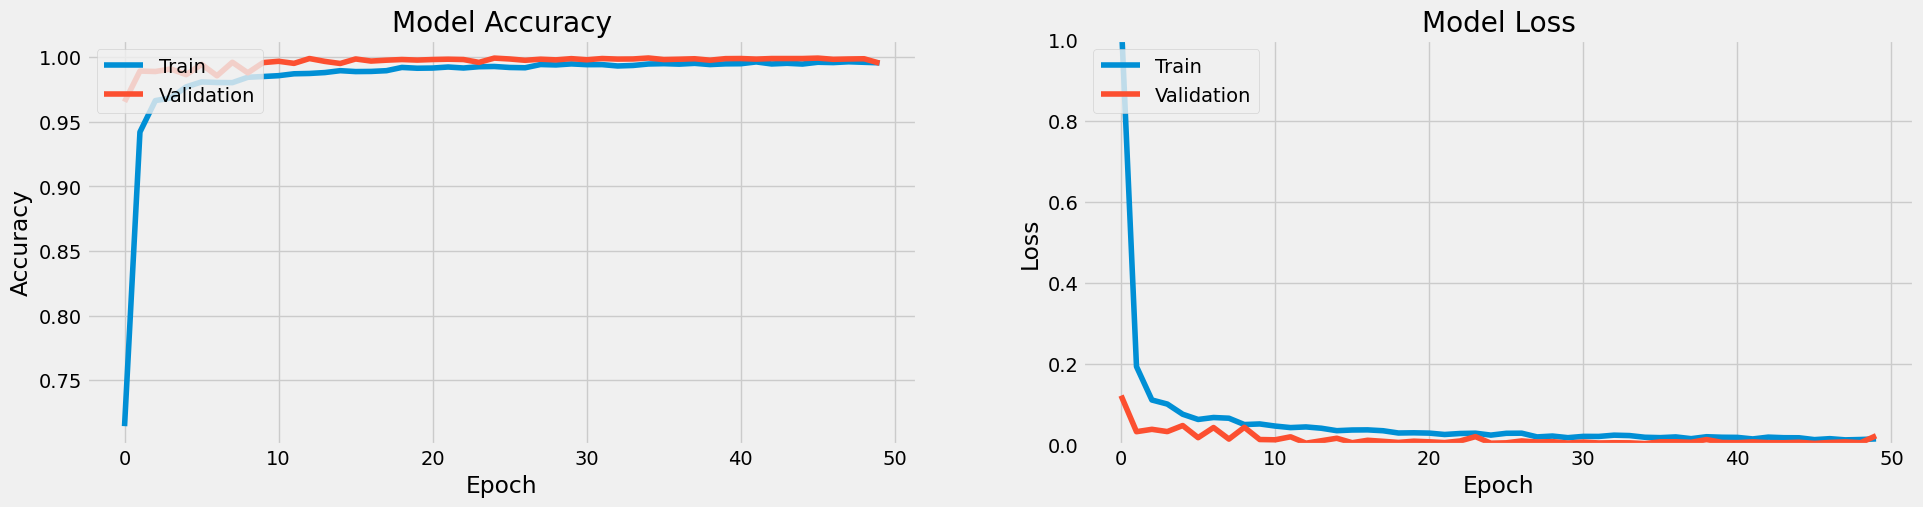

In [24]:
plt.figure(figsize=(21, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [25]:
labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

# pred = model.predict_classes(X_test)
pred_probs = model.predict(X_test)
pred = np.argmax(pred_probs, axis = 1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 3s 8ms/step
Test Data accuracy:  97.56927949326999


In [28]:
cf = confusion_matrix(labels, pred)

<Axes: >

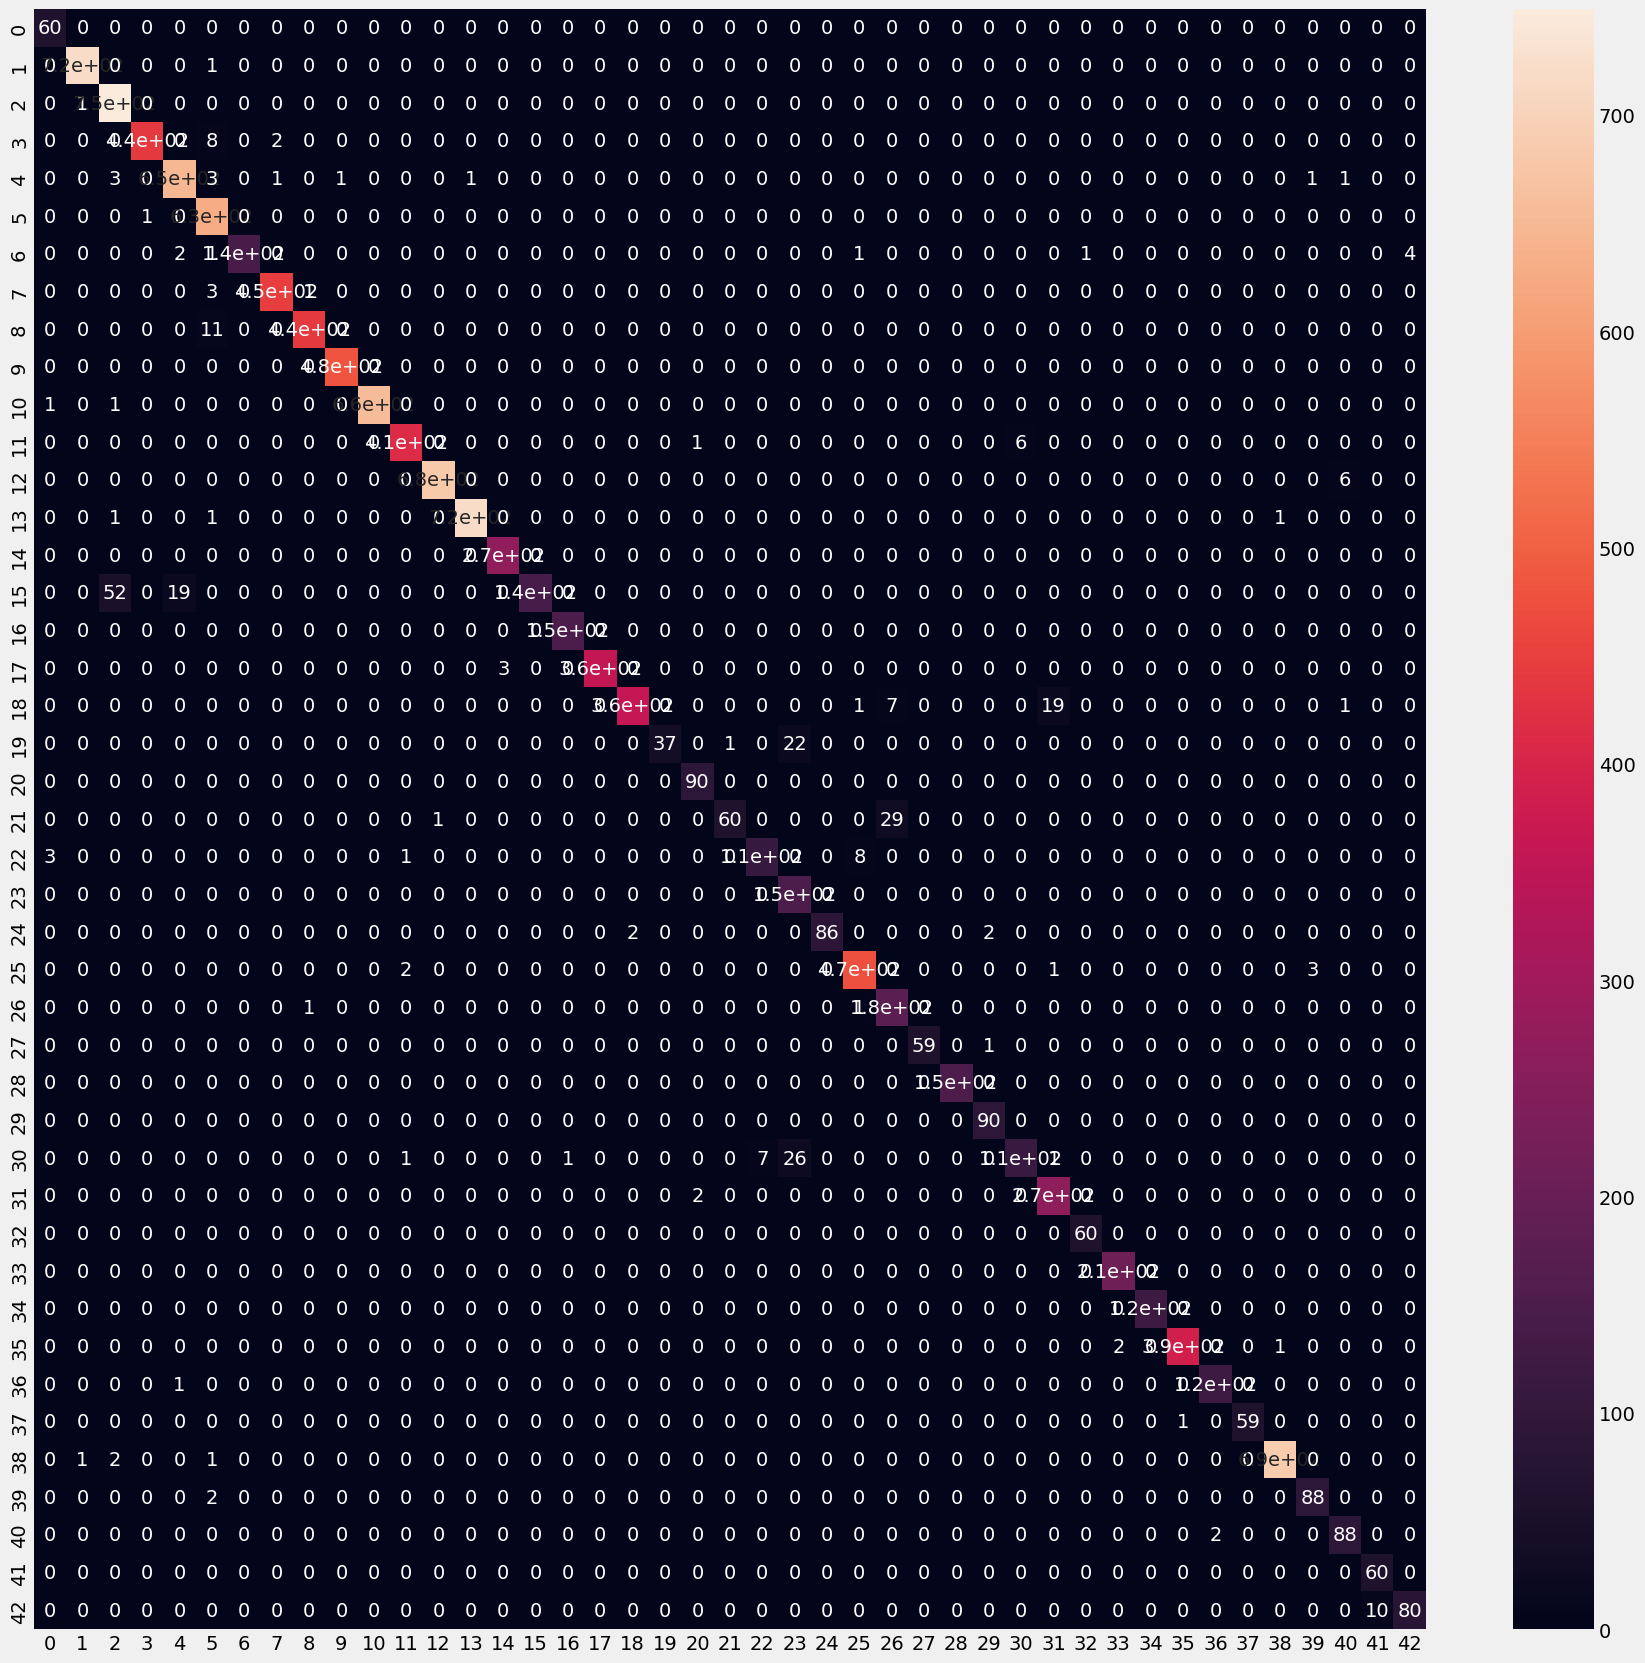

In [29]:
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [31]:
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        60
           1       1.00      1.00      1.00       720
           2       0.93      1.00      0.96       750
           3       1.00      0.98      0.99       450
           4       0.97      0.98      0.98       660
           5       0.95      1.00      0.98       630
           6       1.00      0.94      0.97       150
           7       0.99      0.99      0.99       450
           8       1.00      0.98      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.99      0.98      0.99       420
          12       1.00      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       1.00      0.66      0.80       210
          16       0.99      1.00      1.00       150
          17       1.00    

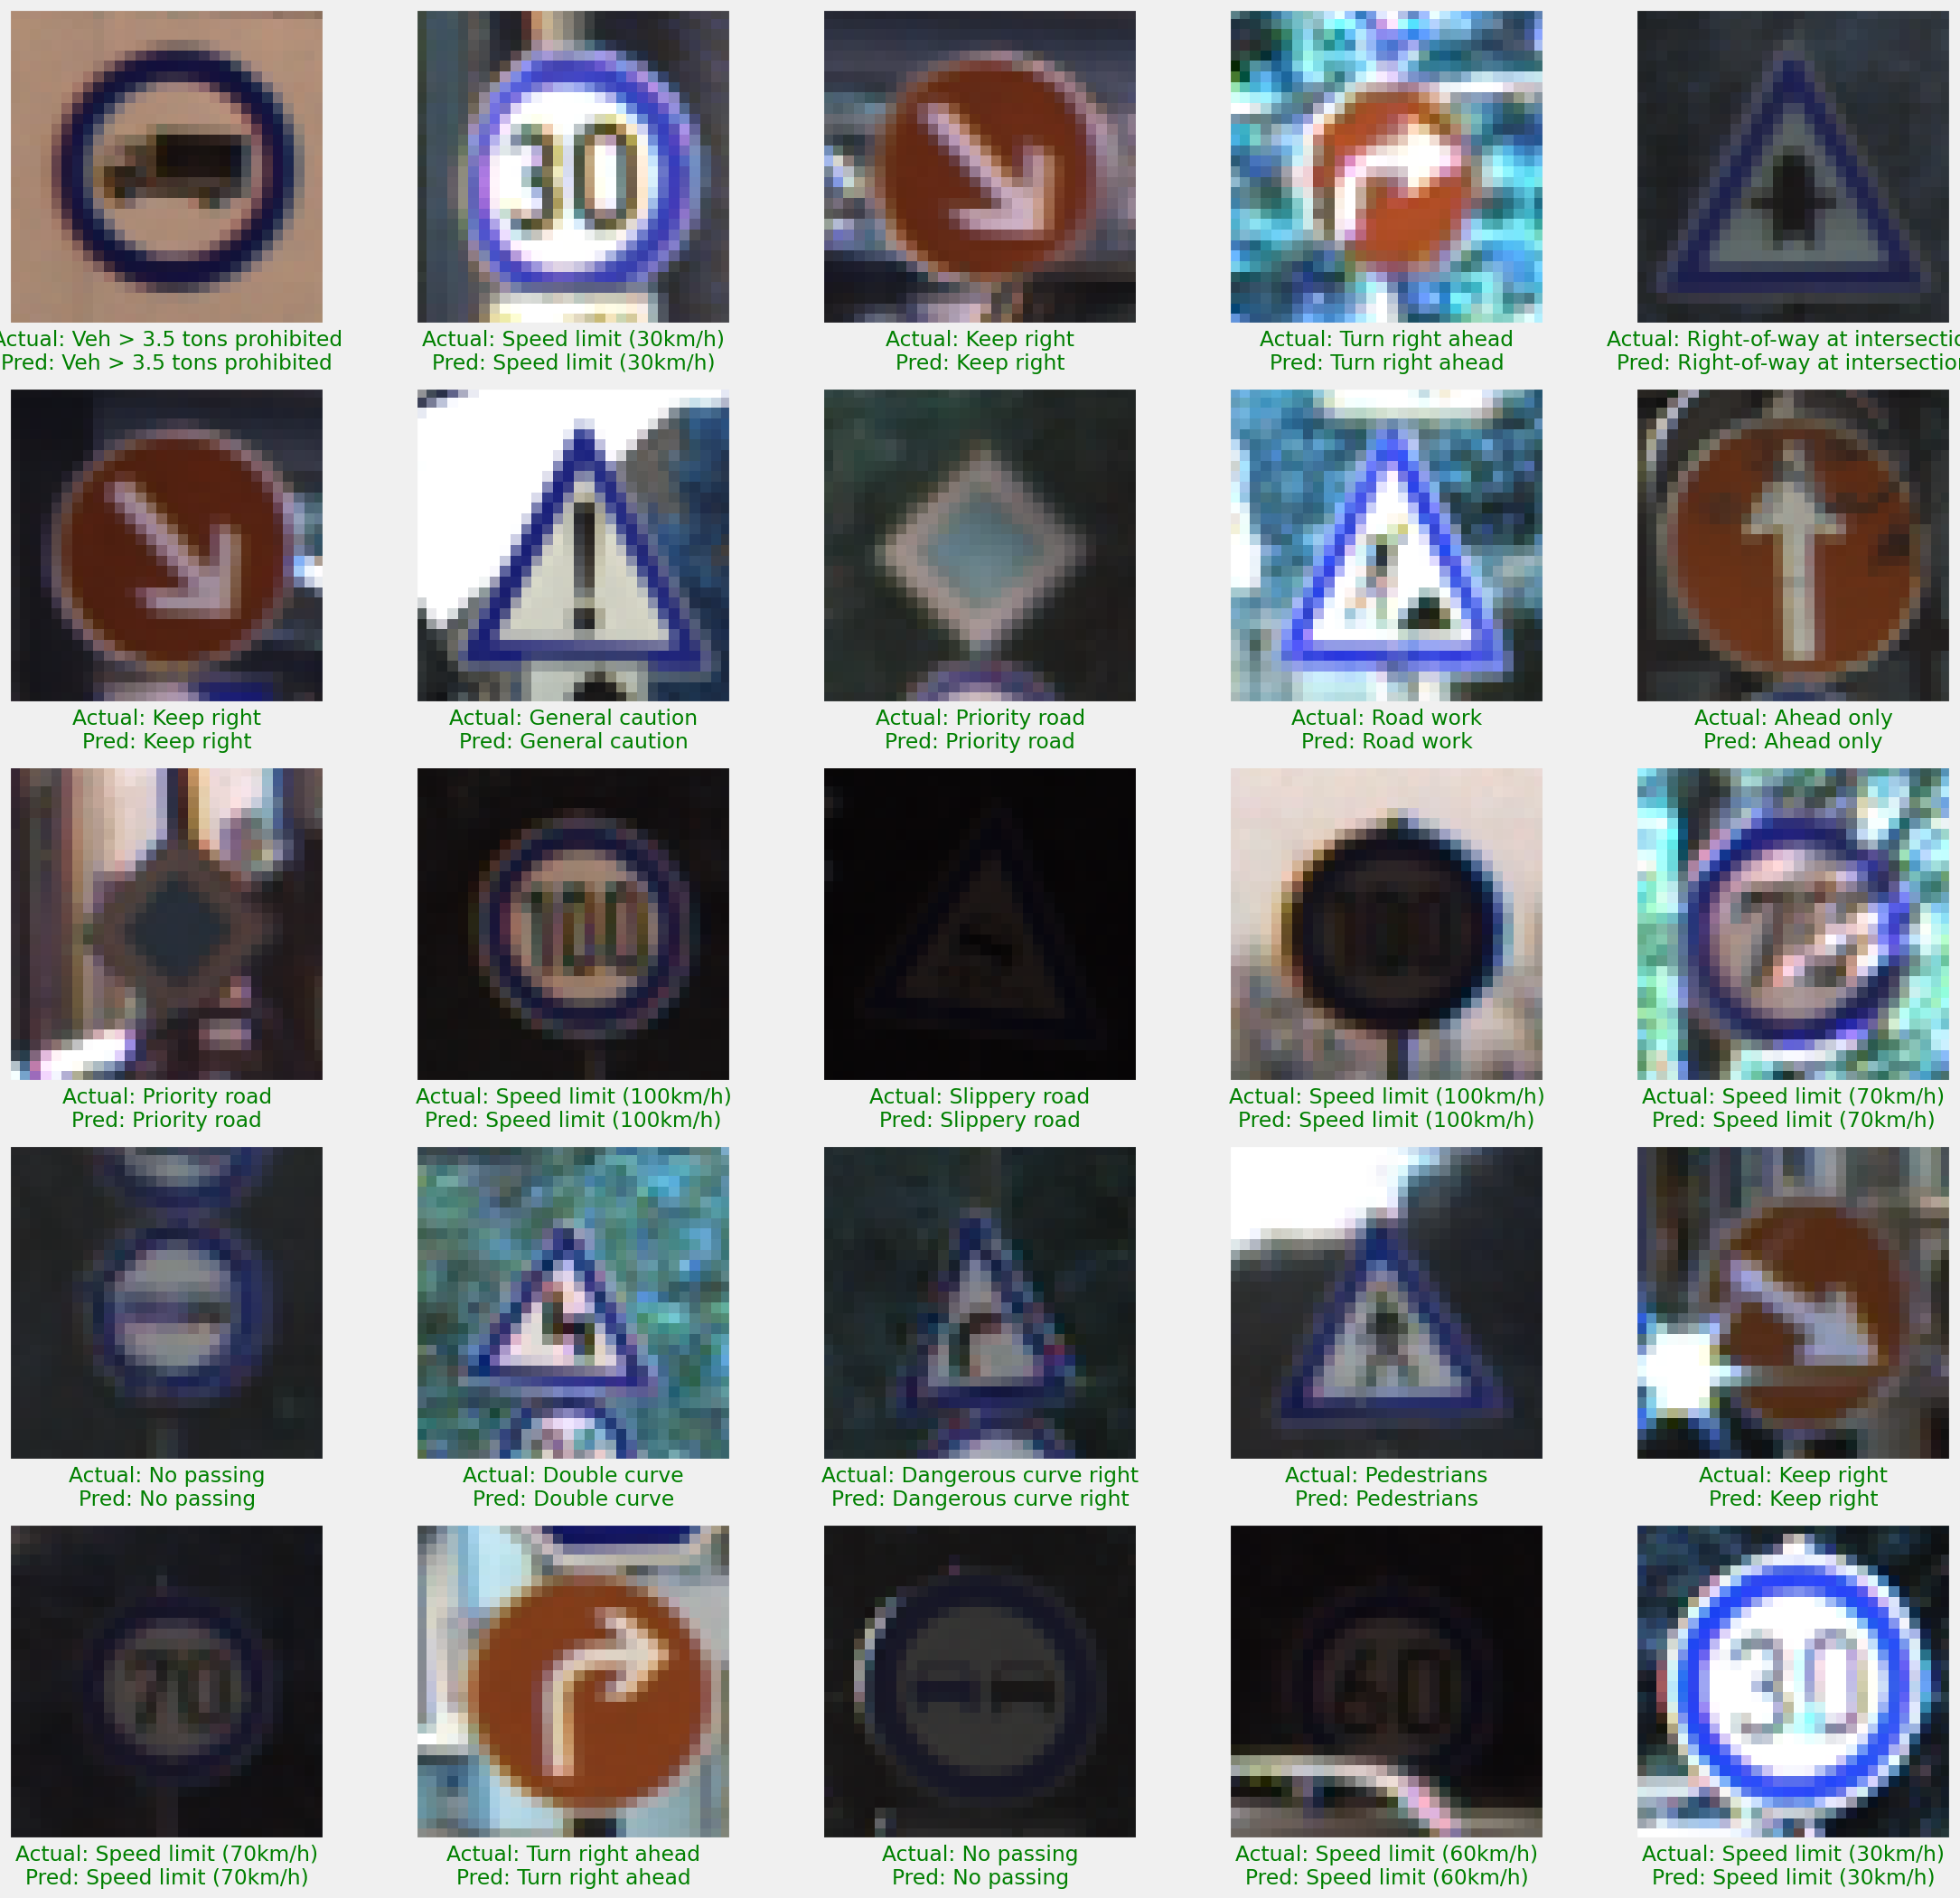

In [35]:
start_index = 0
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    predicted_label = classes[prediction]
    actual_label = classes[actual]
    plt.xlabel('Actual: {}\nPred: {}'.format(actual_label, predicted_label), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

1/1 [==============================] - 0s 169ms/step


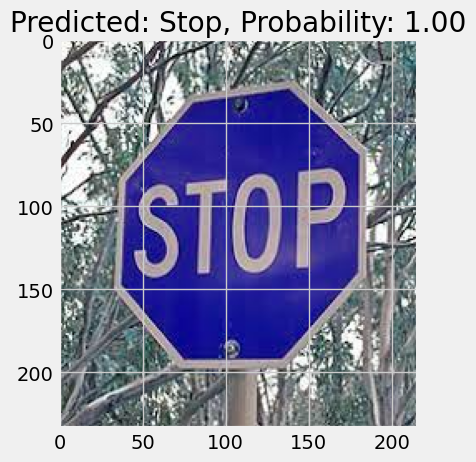

In [9]:
model_path = "model_weights.h5"
model.load_weights(model_path)

# image = cv2.imread("C:/Users/Admin/Desktop/Road-Sign-Recognition/src/road-sign-dataset/Test/00035.png")
image = cv2.imread('C:/Users/Admin/Desktop/Road-Sign-Recognition/src/test_img/test.jpeg')

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((30, 30))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = model.predict(input_data)
result = pred.argmax()
# result

plt.imshow(image)

# Display the prediction
predicted_probability = np.max(pred)
predicted_class = classes.get(result, "Unknown")

# Display the prediction and its probability
plt.title(f'Predicted: {predicted_class}, Probability: {predicted_probability:.2f}')

# Show the plot
plt.show()

1/1 [==============================] - 0s 15ms/step


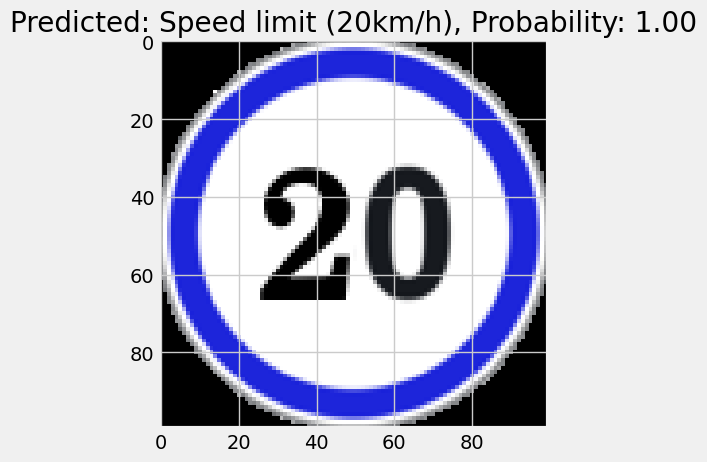

1/1 [==============================] - 0s 15ms/step


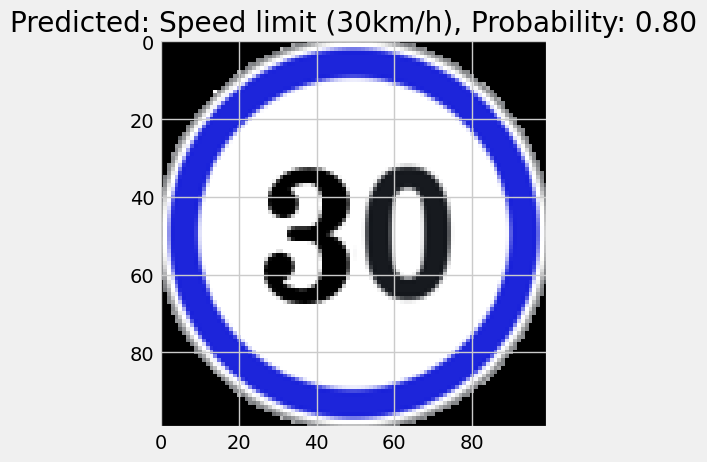

1/1 [==============================] - 0s 16ms/step


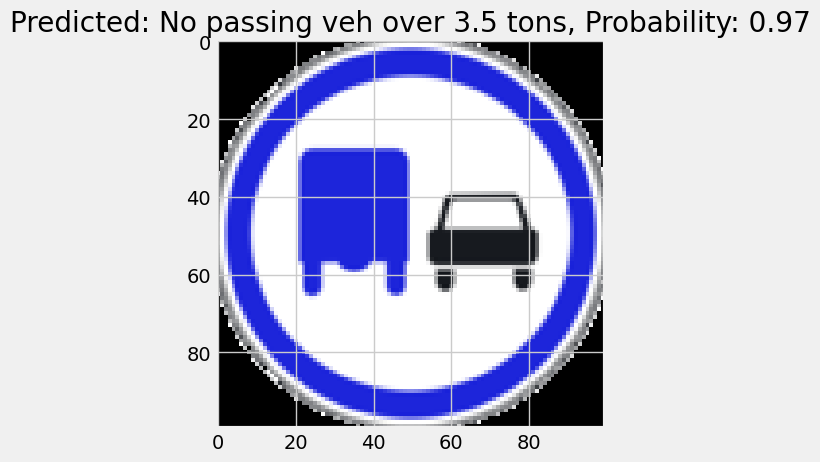

1/1 [==============================] - 0s 15ms/step


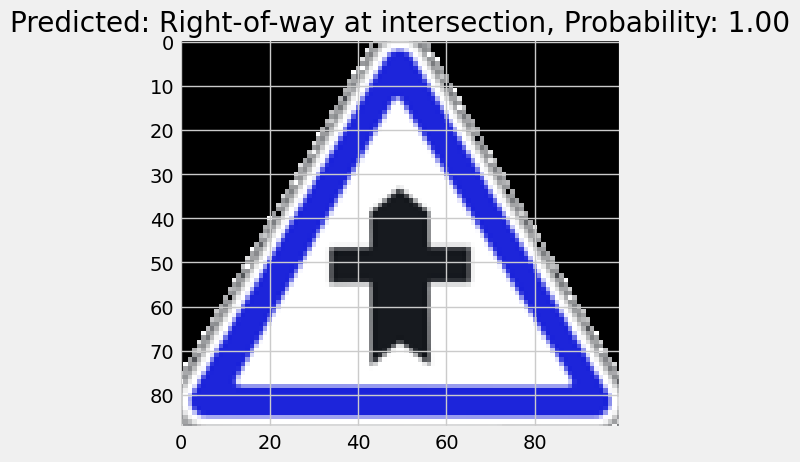

1/1 [==============================] - 0s 16ms/step


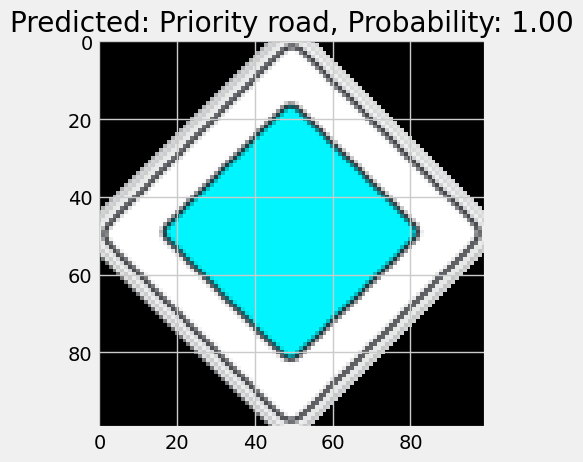

1/1 [==============================] - 0s 16ms/step


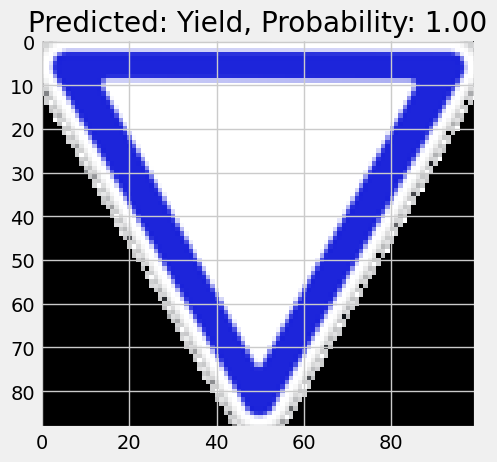

1/1 [==============================] - 0s 16ms/step


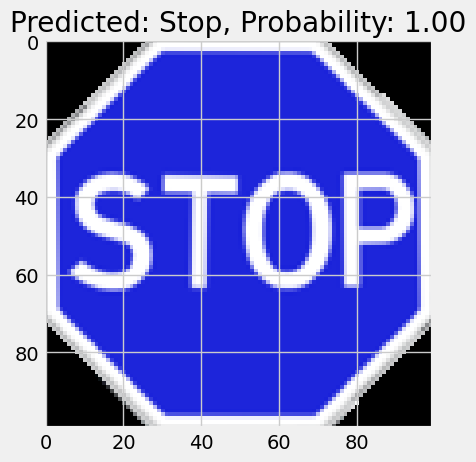

1/1 [==============================] - 0s 15ms/step


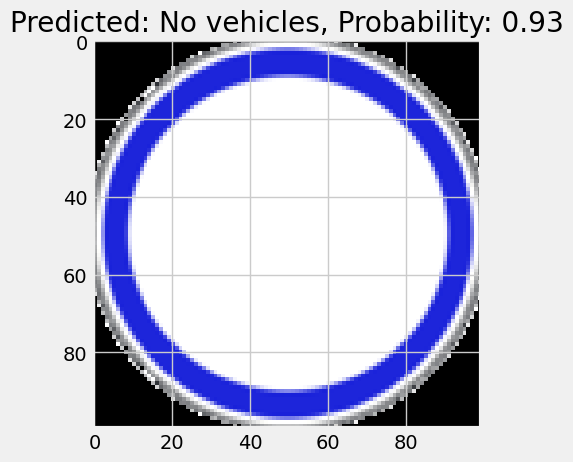

1/1 [==============================] - 0s 15ms/step


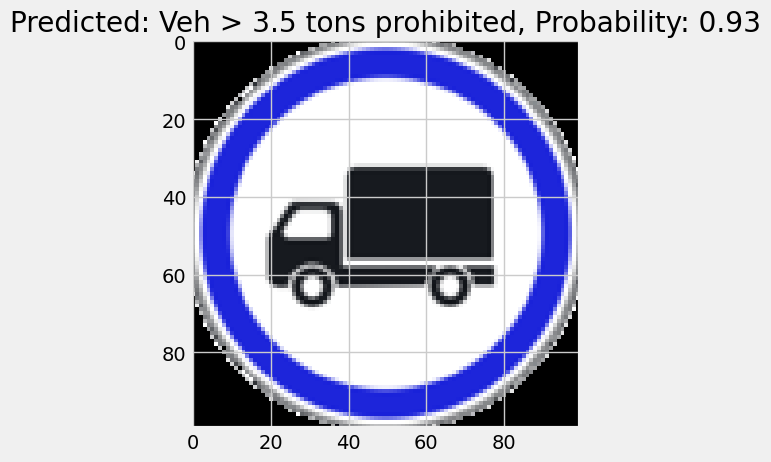

1/1 [==============================] - 0s 16ms/step


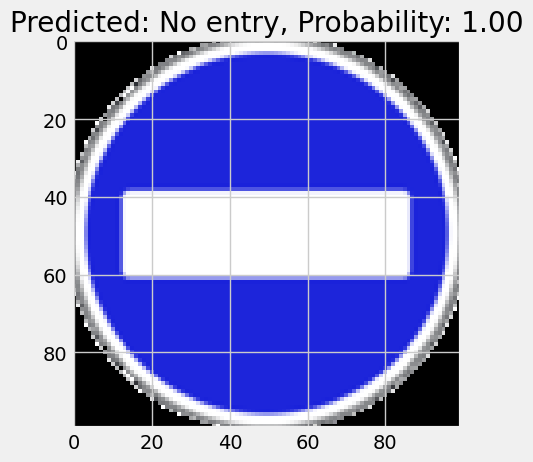

1/1 [==============================] - 0s 15ms/step


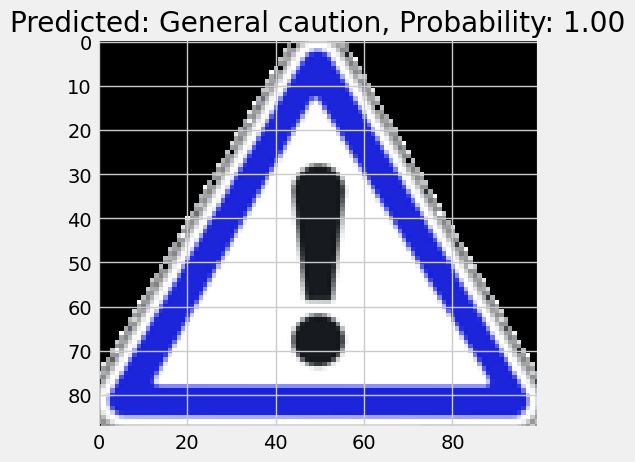

1/1 [==============================] - 0s 15ms/step


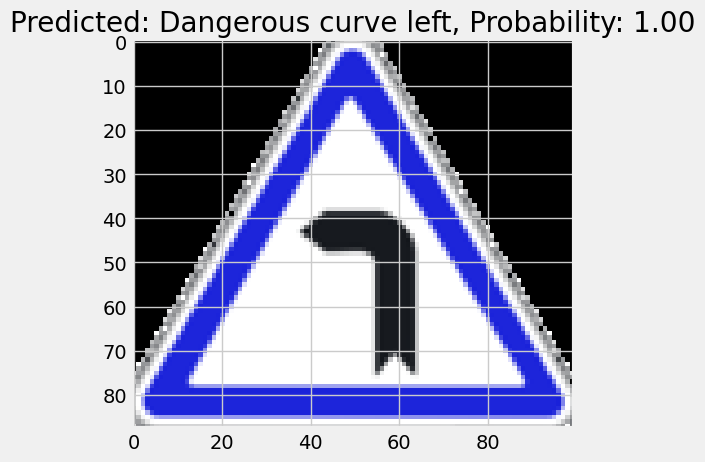

1/1 [==============================] - 0s 16ms/step


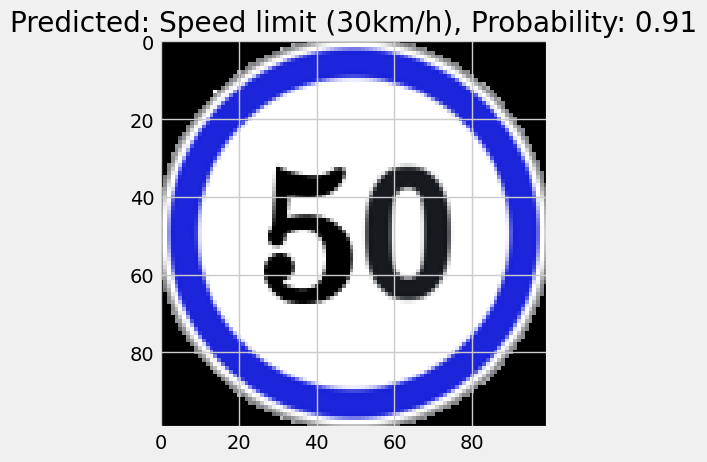

1/1 [==============================] - 0s 17ms/step


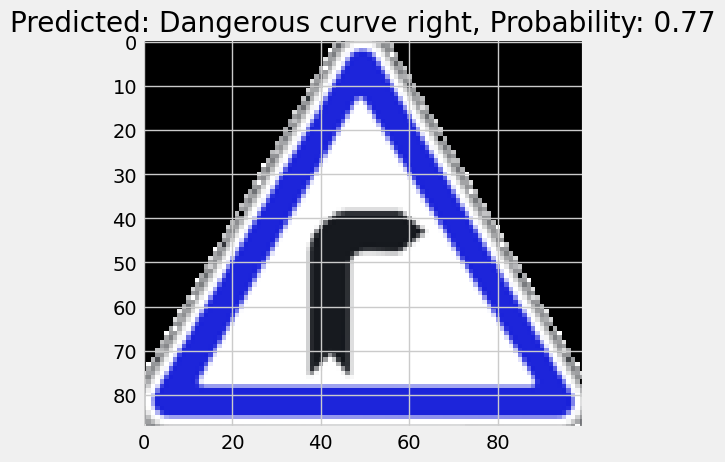

1/1 [==============================] - 0s 16ms/step


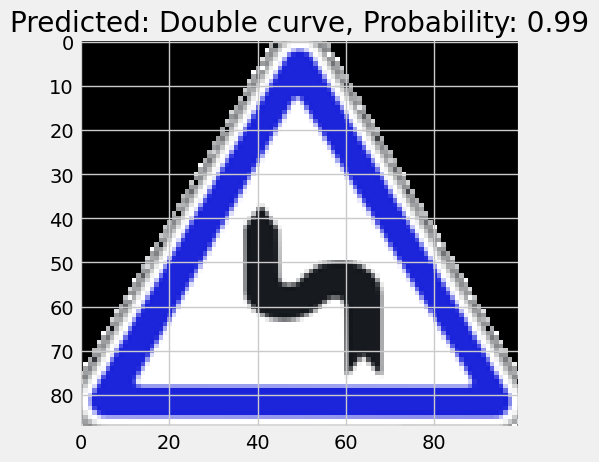

1/1 [==============================] - 0s 15ms/step


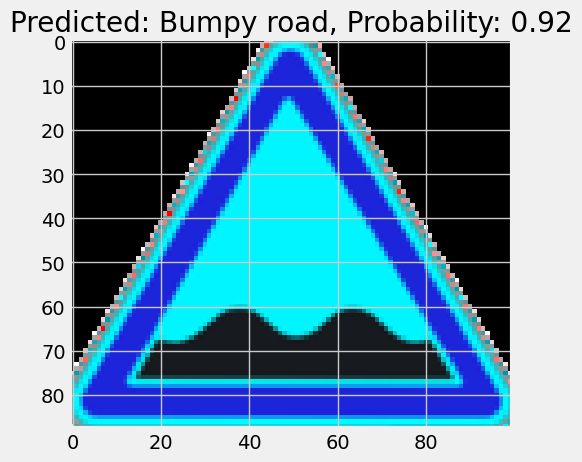

1/1 [==============================] - 0s 18ms/step


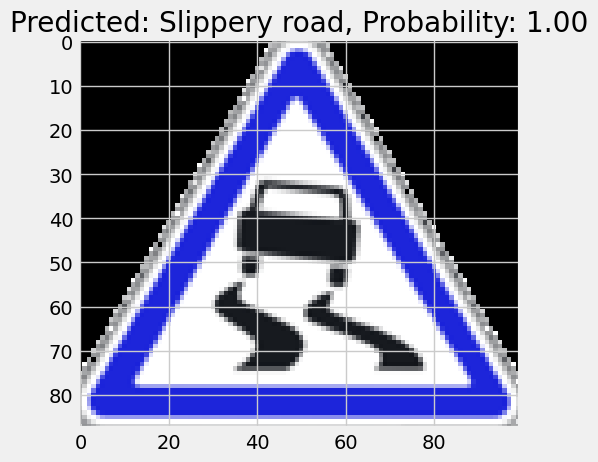

1/1 [==============================] - 0s 15ms/step


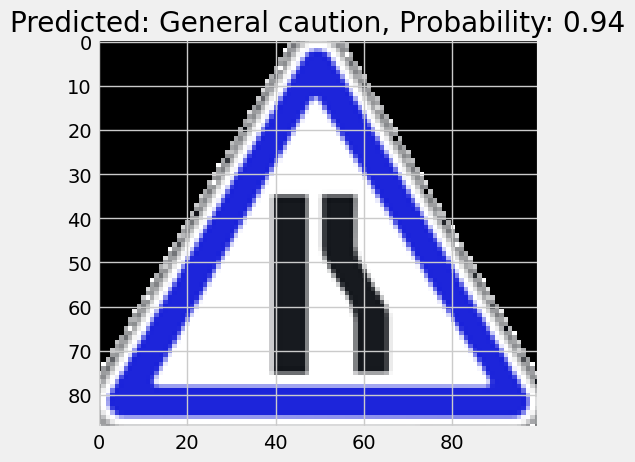

1/1 [==============================] - 0s 15ms/step


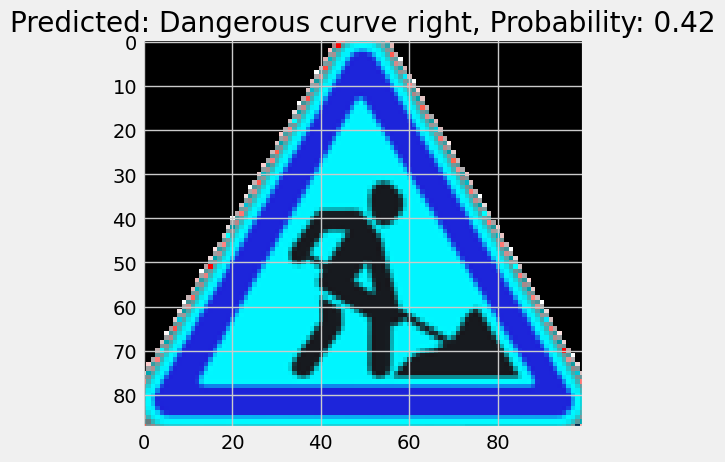

1/1 [==============================] - 0s 16ms/step


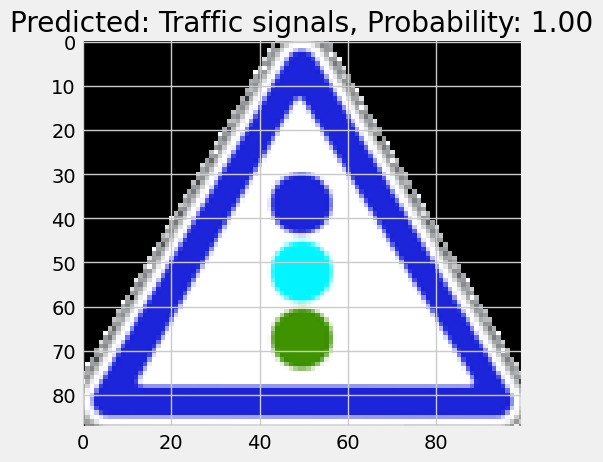

1/1 [==============================] - 0s 15ms/step


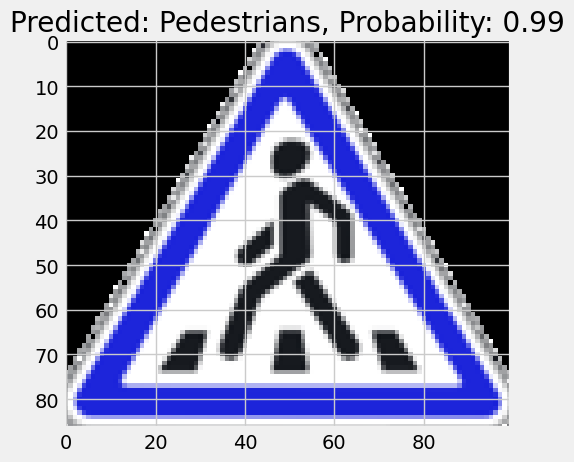

1/1 [==============================] - 0s 17ms/step


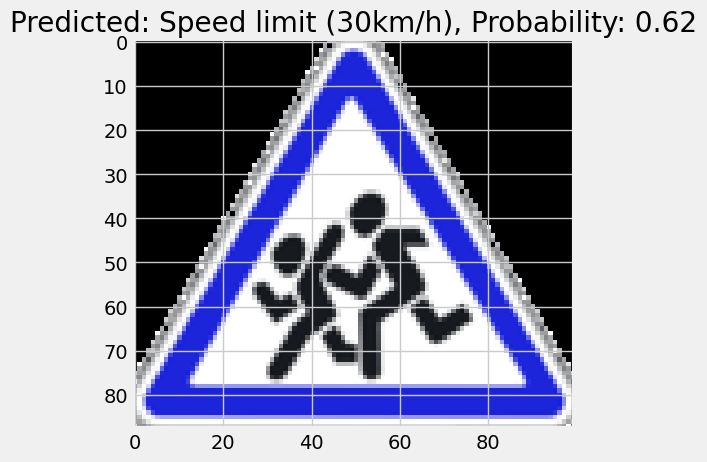

1/1 [==============================] - 0s 16ms/step


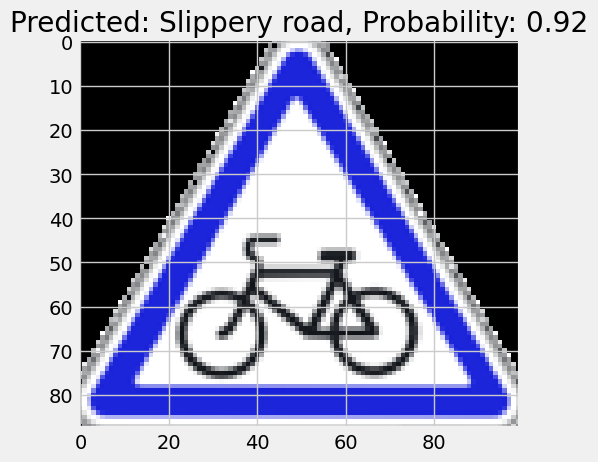

1/1 [==============================] - 0s 18ms/step


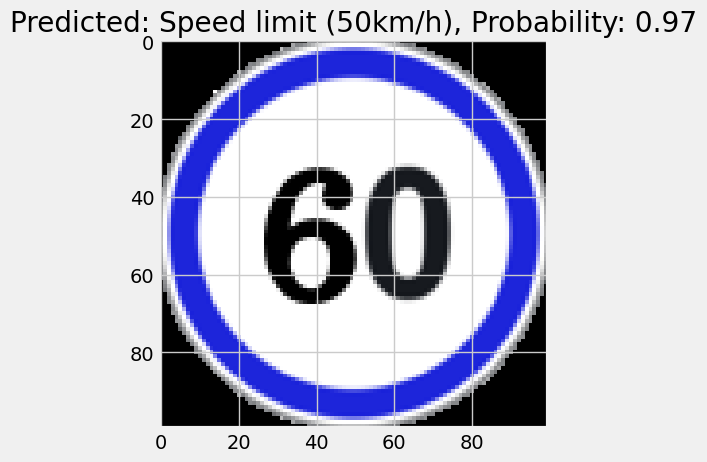

1/1 [==============================] - 0s 14ms/step


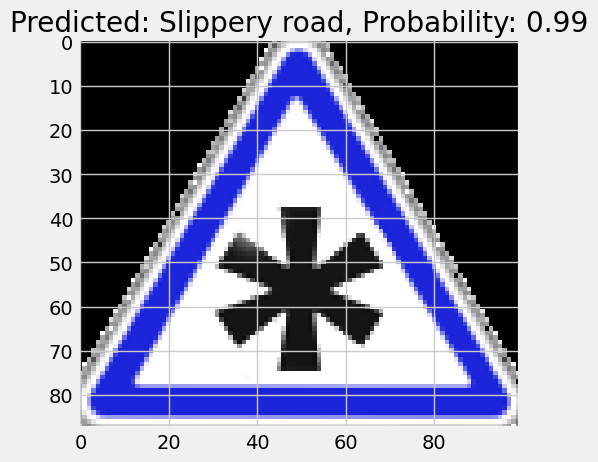

1/1 [==============================] - 0s 16ms/step


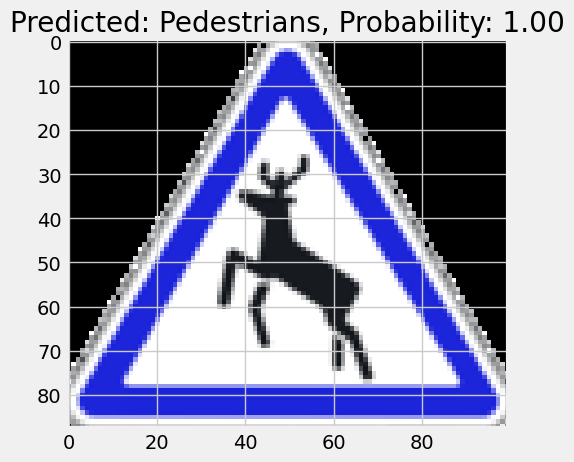

1/1 [==============================] - 0s 16ms/step


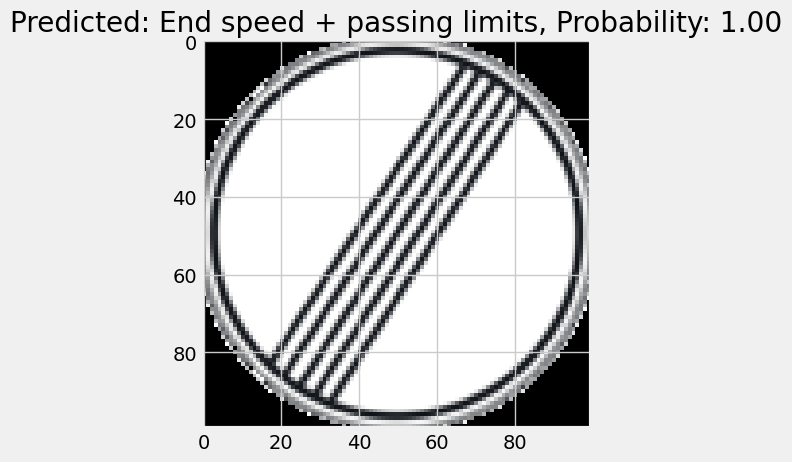

1/1 [==============================] - 0s 19ms/step


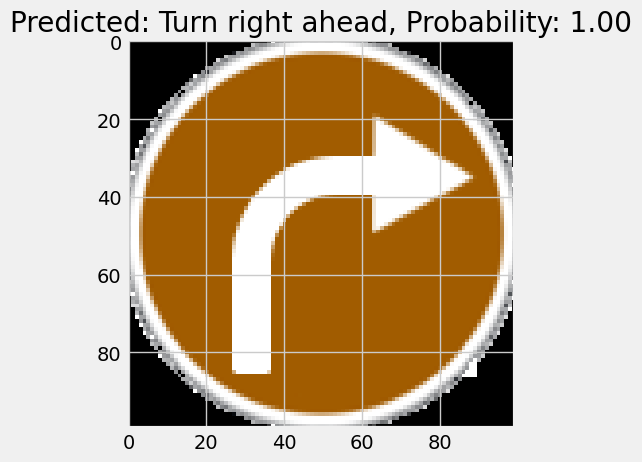

1/1 [==============================] - 0s 16ms/step


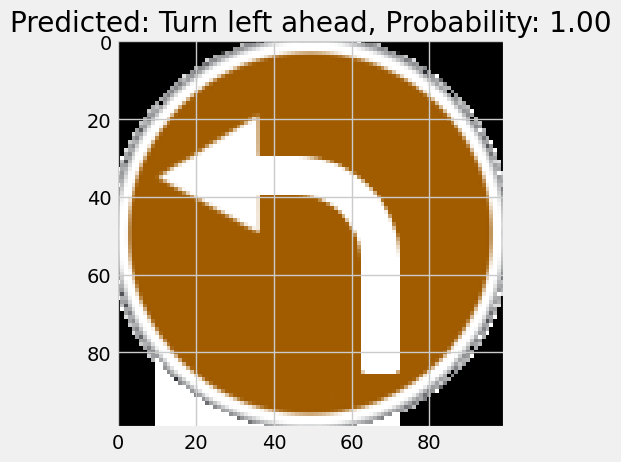

1/1 [==============================] - 0s 16ms/step


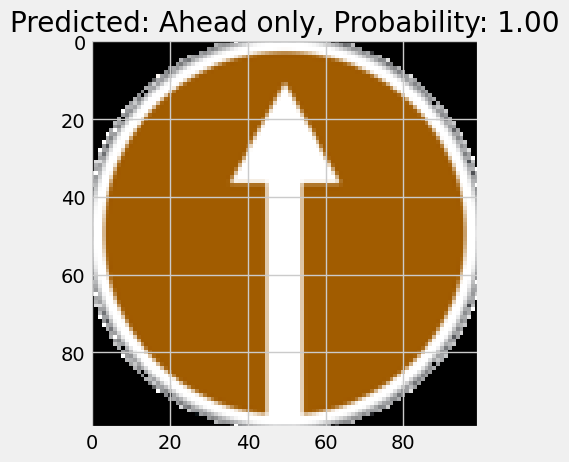

1/1 [==============================] - 0s 19ms/step


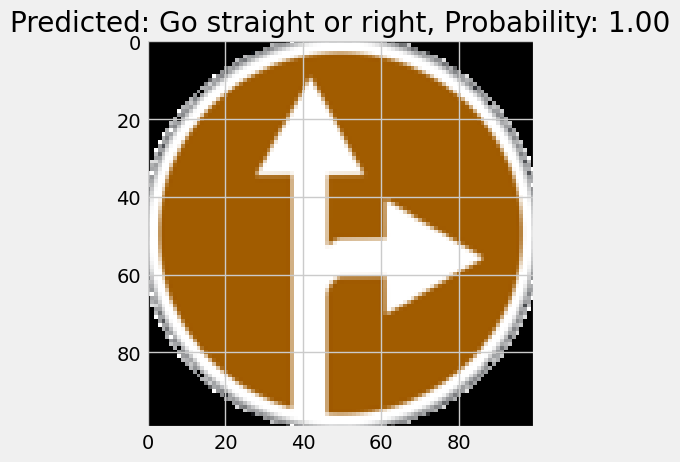

1/1 [==============================] - 0s 18ms/step


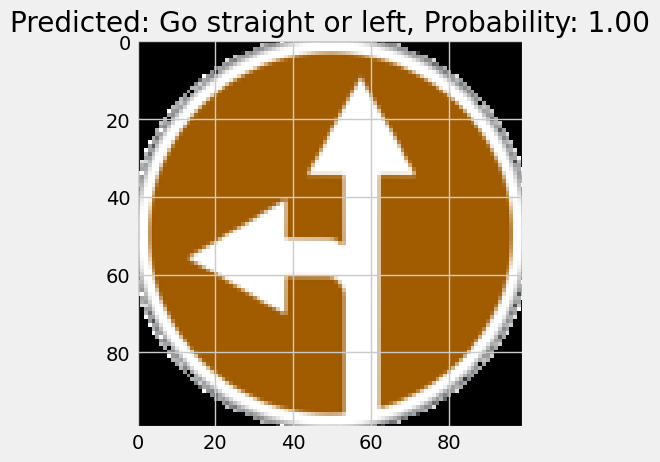

1/1 [==============================] - 0s 16ms/step


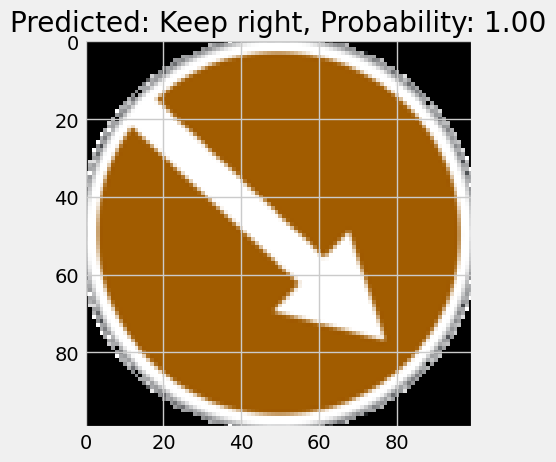

1/1 [==============================] - 0s 19ms/step


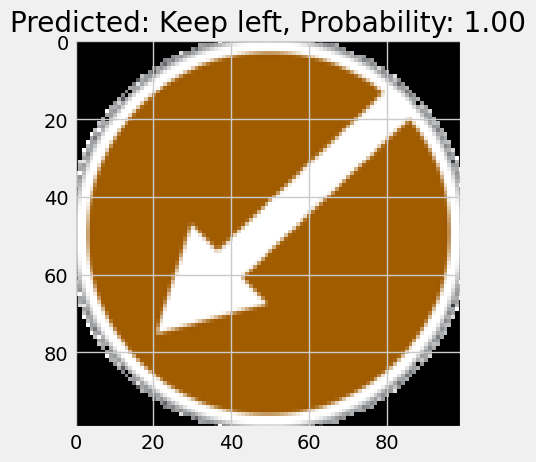

1/1 [==============================] - 0s 16ms/step


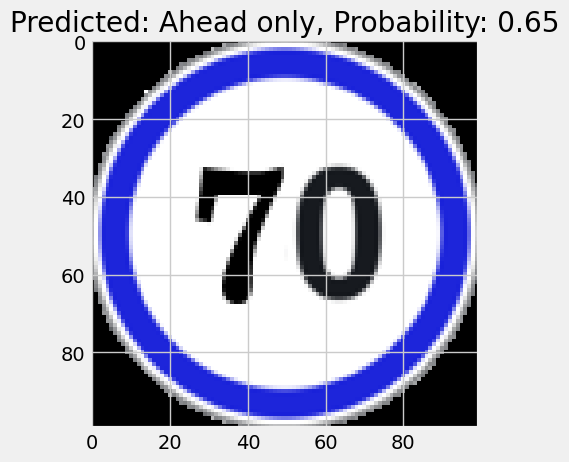

1/1 [==============================] - 0s 16ms/step


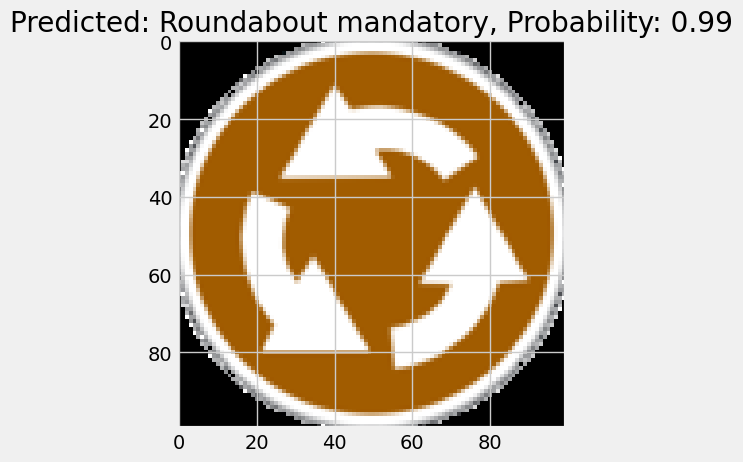

1/1 [==============================] - 0s 16ms/step


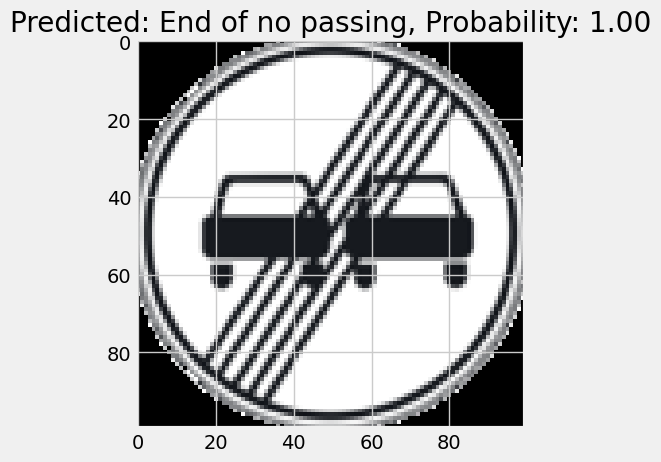

1/1 [==============================] - 0s 16ms/step


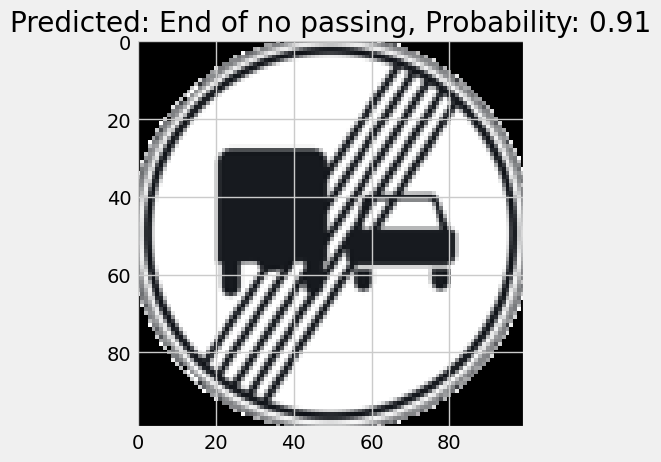

1/1 [==============================] - 0s 22ms/step


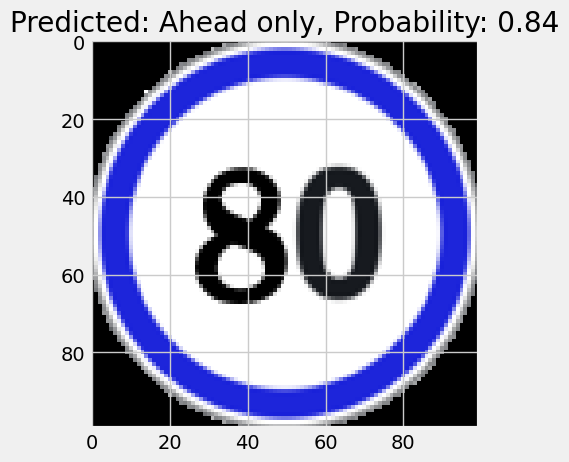

1/1 [==============================] - 0s 16ms/step


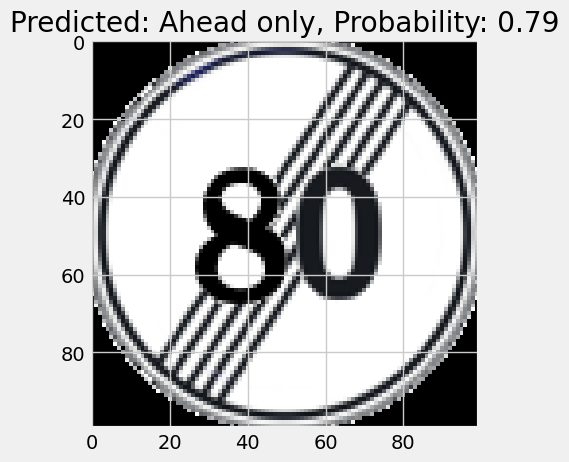

1/1 [==============================] - 0s 17ms/step


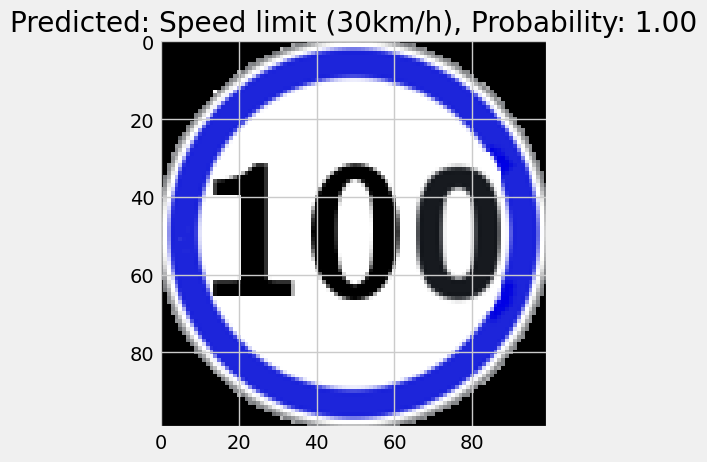

1/1 [==============================] - 0s 22ms/step


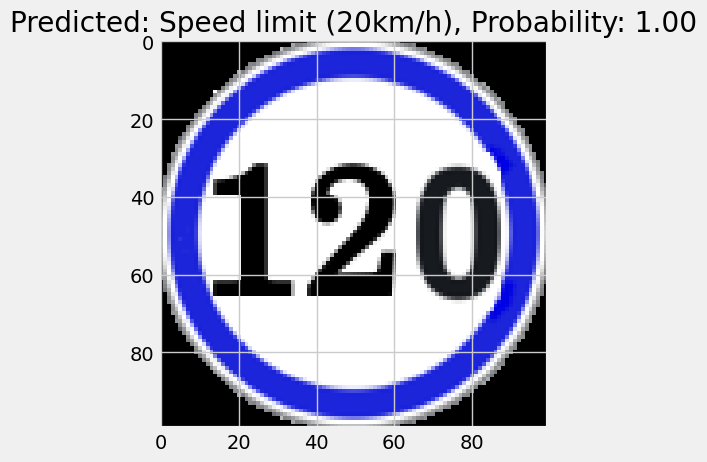

1/1 [==============================] - 0s 16ms/step


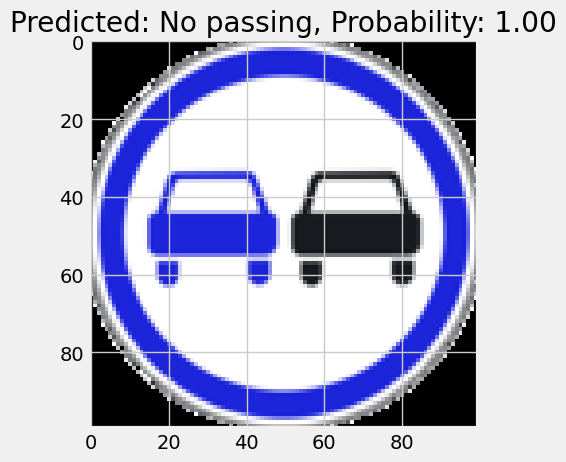

In [10]:
# Load the model
model_path = "model_weights.h5"
model.load_weights(model_path)


# Preprocess and predict the image
def preprocess_and_predict(image_path):
    # Read and preprocess the image
    image = cv2.imread(image_path)
    image_fromarray = Image.fromarray(image, 'RGB')
    resize_image = image_fromarray.resize((30, 30))
    expand_input = np.expand_dims(resize_image, axis=0)
    input_data = np.array(expand_input) / 255

    # Predict the class
    pred = model.predict(input_data)
    result = pred.argmax()
    predicted_probability = np.max(pred)
    predicted_class = classes.get(result, "Unknown")

    # Display the image and prediction
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}, Probability: {predicted_probability:.2f}')
    plt.show()

# Path to the folder containing testing images
folder_path = 'C:/Users/Admin/Desktop/Road-Sign-Recognition/src/road-sign-dataset/Meta'

# Loop through all images in the folder and predict
for image_file in os.listdir(folder_path):
    image_path = os.path.join(folder_path, image_file)
    if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        preprocess_and_predict(image_path)
